In [1]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 1. Get the data from the Wikipedia page

In [2]:
# obtain the data from Wikipedia page
table_canada = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = table_canada[0]
df.head()


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Ignore cells with a borough that is Not assigned
canada_data = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
canada_data.rename(columns={'Neighbourhood':'Neighborhood'}, inplace = True)
canada_data.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
canada_data.shape[0]

103

# 2. Get the latitude and the longitude coordinates of each neighborhood

In [5]:
# read geographical coordinates of the neighborhoods data
geo_url = "https://cocl.us/Geospatial_data" 
geo_df = pd.read_csv(geo_url)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# link geographical coordinates to the neighborhoods
neighborhood_data = pd.merge(canada_data, geo_df, on='Postal Code')
neighborhood_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# 3. Explore and cluster the neighborhoods in Toronto

## 3.1 Neighborhoods in Toronto

In [7]:

toronto_data = neighborhood_data[neighborhood_data['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [8]:
# for latitude and logitude of Toronto
latitude = 43.657952
longitude = -79.387383
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [9]:
# The code was removed by Watson Studio for sharing.

##  3.2 Explore neighborhoods in Toronto

In [10]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [12]:
print(toronto_venues.shape)
toronto_venues.head()

(1212, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 206 uniques categories.


## 3.3 Analyze Each Neighborhood

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [15]:
toronto_onehot.shape

(1212, 206)

In [16]:
toronto_grouped =toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0,0.018519,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.018519,0.037037,0.000000,0.000000,0.0,0.018519,0.018519,0.0,0.037037,0.0,0.0,0.018519,0.0000,0.0000,0.0000,0.0,0.018519,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0000,0.018519,0.0000,0.0000,0.037037,0.0,0.0,0.0,0.018519,0.055556,0.092593,0.0,0.0,0.0,0.0,0.0,0.0,0.018519,0.000000,0.018519,0.0,0.0,0.018519,0.0,0.0000,0.0,0.018519,0.0000,0.018519,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.018519,0.0,0.0000,0.0,0.000000,0.037037,0.000,0.0,0.018519,0.0000,0.0,0.0,0.018519,0.018519,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.018519,0.018519,0.018519,0.000000,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.018519,0.018519,0.0,0.018519,0.000000,0.0,0.0,0.0,0.018519,0.0,0.0,0.0000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.018519,0.0,0.0000,0.018519,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0

Restaurant total and variety distribution


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28b53596d0>,
      dtype=object)

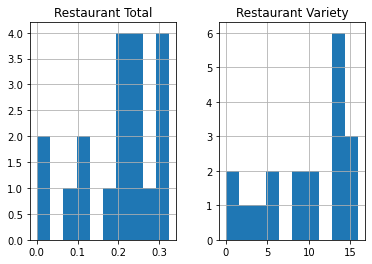

In [17]:
restaurant_columns = [c for c in toronto_grouped.columns if 'Restaurant' in c or c == 'Neighborhood']
toronto_grouped_restaurant = toronto_grouped[restaurant_columns]
pd.set_option('mode.chained_assignment', None)
Total, Variety = [], []
for row in toronto_grouped_restaurant.iterrows():
    total = 0
    variety = 0
    for col in row[1][1:]:
        total += float(col)
        variety += 1 if col > 0 else 0
    Total.append(total)
    Variety.append(variety)
toronto_grouped_restaurant['Restaurant Total'] = Total
toronto_grouped_restaurant['Restaurant Variety'] = Variety

toronto_restaurant = toronto_grouped_restaurant[['Neighborhood','Restaurant Total','Restaurant Variety']]
print("Restaurant total and variety distribution")
toronto_restaurant[['Restaurant Total', 'Restaurant Variety']].hist()

In [18]:
total_frequency_rank = toronto_restaurant.sort_values(by=['Restaurant Total'], ascending=False)
variety_rank = toronto_restaurant.sort_values(by=['Restaurant Variety'], ascending=False)
print("Top 5 neighborhood by total restaurants") 
total_frequency_rank.head()

Top 5 neighborhood by total restaurants


,Neighborhood,Restaurant Total,Restaurant Variety
4,Church and Wellesley,0.325000,14
5,"Commerce Court, Victoria Hotel",0.310000,13
6,"First Canadian Place, Underground city",0.300000,16
9,"Kensington Market, Chinatown, Grange Park",0.295082,10
14,St. James Town,0.269231,15


In [19]:
print("Top 5 neighborhood by variety") 
variety_rank.head()

Top 5 neighborhood by variety


,Neighborhood,Restaurant Total,Restaurant Variety
12,"Richmond, Adelaide, King",0.244681,16
6,"First Canadian Place, Underground city",0.300000,16
14,St. James Town,0.269231,15
17,"Toronto Dominion Centre, Design Exchange",0.260000,14
4,Church and Wellesley,0.325000,14


## 3.4 Cluster Neighborhoods

1     CN Tower, King and Spadina, Railway Lands, Har...
13                                             Rosedale
Name: Neighborhood, dtype: object


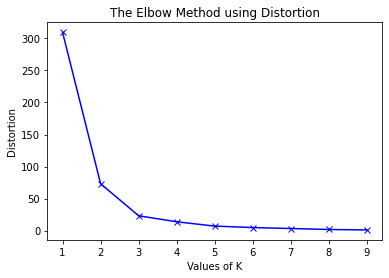

In [35]:
# set number of clusters
import matplotlib.pyplot as plt
K = range(1,10)
distortions = []
total_frequency_rank = toronto_grouped_restaurant.sort_values(by=['Restaurant Total'], ascending=False)
droplist = total_frequency_rank[total_frequency_rank['Restaurant Total']==0]['Neighborhood']
print(droplist)
total_frequency_rank = total_frequency_rank[total_frequency_rank['Restaurant Total']!=0]

toronto_grouped_clustering = total_frequency_rank.drop('Neighborhood', 1)

for kclusters in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

# hence choose k=4
toronto_grouped_clustering = total_frequency_rank.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(toronto_grouped_clustering)

In [21]:
total_frequency_rank.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data
for n in droplist:
    toronto_merged = toronto_merged[toronto_merged['Neighborhood'] != n]
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(total_frequency_rank.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(20) # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.090909,4
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.0000,0.000000,0.00000,0.187500,5
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0100,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.030000,0.000000,0.000000,0.000000,0.010000,0.030000,0.010000,0.000000,0.000000,0.010000,0.000000,0.020000,0.010000,0.010000,0.000000,0.000000,0.010000,0.0000,0.000000,0.01000,0.220000,14
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,0.038462,0.012821,0.012821,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.012821,0.012821,0.000000,0.000000,0.000000,0.025641,0.012821,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.025641,0.012821,0.000000,0.000000,0.025641,0.025641,0.000000,0.000000,0.012821,0.0000,0.012821,0.00000,0.269231,15
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.018519,0.0000,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.018519,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.018519,0.000000,0.018519,0.0000,0.018519,0.00000,0.222222,10
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.016393,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.016393,0.049180,0.016393,0.016393,0.000000,0.000000,0.000000,0.016393,0.016393,0.000000,0.000000,0.000000,0.016393,0.016393,0.000000,0.000000,0.016393,0.000000,0.016393,0.0000,0.016393,0.00000,0.245902,13
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0

In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 3.5 Examine Clusters

### cluster 1

In [23]:
print("This cluster has a few restaurant. These are not recommended to open restaruants.")
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

This cluster has a few restaurant. These are not recommended to open restaruants.


,Neighborhood,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
2,"Garden District, Ryerson",0,0.000000,0.00,0.0,0.0,0.0000,0.01,0.0,0.000000,0.0,0.0,0.000000,0.0100,0.000000,0.020000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.030000,0.030000,0.000000,0.00,0.000,0.0100,0.030000,0.010000,0.000000,0.0,0.01,0.000000,0.020000,0.010000,0.010000,0.000000,0.0,0.010000,0.0000,0.000000,0.01,0.220000,14
5,Central Bay Street,0,0.000000,0.00,0.0,0.0,0.0000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.016393,0.000000,0.0,0.016393,0.0,0.00,0.00,0.016393,0.049180,0.016393,0.016393,0.00,0.000,0.0000,0.016393,0.016393,0.000000,0.0,0.00,0.016393,0.016393,0.000000,0.000000,0.016393,0.0,0.016393,0.0000,0.016393,0.00,0.245902,13
9,"Toronto Dominion Centre, Design Exchange",0,0.030000,0.02,0.0,0.0,0.0000,0.01,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.010000,0.0,0.010000,0.0,0.01,0.01,0.000000,0.030000,0.030000,0.000000,0.00,0.000,0.0000,0.000000,0.000000,0.000000,0.0,0.01,0.000000,0.000000,0.030000,0.030000,0.020000,0.0,0.000000,0.0000,0.010000,0.00,0.260000,14
10,"Commerce Court, Victoria Hotel",0,0.040000,0.01,0.0,0.0,0.0000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.010000,0.0,0.010000,0.0,0.01,0.00,0.000000,0.040000,0.030000,0.000000,0.01,0.000,0.0000,0.000000,0.000000,0.000000,0.0,0.01,0.000000,0.000000,0.070000,0.030000,0.000000,0.0,0.020000,0.0000,0.020000,0.00,0.310000,13
15,Stn A PO Boxes,0,0.010309,0.00,0.0,0.0,0.0000,0.00,0.0,0.010309,0.0,0.0,0.010309,0.0000,0.000000,0.010309,0.0,0.010309,0.0,0.00,0.00,0.000000,0.030928,0.030928,0.000000,0.00,0.000,0.0000,0.000000,0.000000,0.010309,0.0,0.00,0.000000,0.000000,0.030928,0.041237,0.010309,0.0,0.010309,0.0000,0.010309,0.00,0.226804,13
18,Church and Wellesley,0,0.012500,0.00,0.0,0.0,0.0125,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0125,0.000000,0.025000,0.0,0.000000,0.0,0.00,0.00,0.012500,0.000000,0.062500,0.012500,0.00,0.025,0.0125,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.012500,0.037500,0.000000,0.062500,0.0,0.012500,0.0125,0.000000,0.00,0.325000,14


In [24]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
total1 = cluster1.sum(axis=0)
total1.name = 'Cluster 1'
cluster1 = cluster1.append(total1)
cluster_summary1 = cluster1.iloc[-1]
clean1 = cluster1.drop([c for c in cluster1.columns if cluster_summary1[c]==0], axis=1)
clean1.at['Cluster 1', 'Restaurant Variety']=len(clean1.columns) - 3
clean1

,Neighborhood,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
2,"Garden District, Ryerson",0.000000,0.00,0.0000,0.01,0.000000,0.000000,0.0100,0.000000,0.020000,0.000000,0.00,0.00,0.000000,0.030000,0.030000,0.000000,0.00,0.000,0.0100,0.030000,0.010000,0.000000,0.01,0.000000,0.020000,0.010000,0.010000,0.000000,0.010000,0.0000,0.000000,0.01,0.220000,14
5,Central Bay Street,0.000000,0.00,0.0000,0.00,0.000000,0.000000,0.0000,0.016393,0.000000,0.016393,0.00,0.00,0.016393,0.049180,0.016393,0.016393,0.00,0.000,0.0000,0.016393,0.016393,0.000000,0.00,0.016393,0.016393,0.000000,0.000000,0.016393,0.016393,0.0000,0.016393,0.00,0.245902,13
9,"Toronto Dominion Centre, Design Exchange",0.030000,0.02,0.0000,0.01,0.000000,0.000000,0.0000,0.000000,0.010000,0.010000,0.01,0.01,0.000000,0.030000,0.030000,0.000000,0.00,0.000,0.0000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.030000,0.030000,0.020000,0.000000,0.0000,0.010000,0.00,0.260000,14
10,"Commerce Court, Victoria Hotel",0.040000,0.01,0.0000,0.00,0.000000,0.000000,0.0000,0.000000,0.010000,0.010000,0.01,0.00,0.000000,0.040000,0.030000,0.000000,0.01,0.000,0.0000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.070000,0.030000,0.000000,0.020000,0.0000,0.020000,0.00,0.310000,13
15,Stn A PO Boxes,0.010309,0.00,0.0000,0.00,0.010309,0.010309,0.0000,0.000000,0.010309,0.010309,0.00,0.00,0.000000,0.030928,0.030928,0.000000,0.00,0.000,0.0000,0.000000,0.000000,0.010309,0.00,0.000000,0.000000,0.030928,0.041237,0.010309,0.010309,0.0000,0.010309,0.00,0.226804,13
18,Church and Wellesley,0.012500,0.00,0.0125,0.00,0.000000,0.000000,0.0125,0.000000,0.025000,0.000000,0.00,0.00,0.012500,0.000000,0.062500,0.012500,0.00,0.025,0.0125,0.000000,0.000000,0.000000,0.00,0.000000,0.012500,0.037500,0.000000,0.062500,0.012500,0.0125,0.000000,0.00,0.325000,14
Cluster 1,"Garden District, RyersonCentral Bay StreetToro...",0.092809,0.03,0.0125,0.02,0.010309,0.010309,0.0225,0.016393,0.075309,0.046703,0.02,0.01,0.028893,0.180108,0.199821,0.028893,0.01,0.025,0.0225,0.046393,0.026393,0.010309,0.03,0.016393,0.048893,0.178428,0.111237,0.109203,0.069203,0.0125,0.056703,0.01,1.587706,32


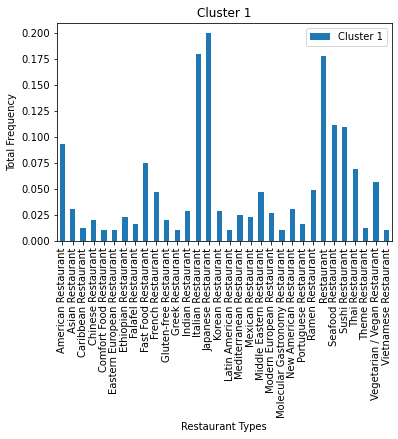

In [25]:
Restaurant_types = clean1.columns.tolist()
Restaurant_counts = clean1.drop(['Neighborhood','Restaurant Total','Restaurant Variety'],axis=1).tail(1)

Restaurant_counts
x_pos1 = [i for i, _ in enumerate(Restaurant_types)]
Restaurant_counts.transpose().plot.bar(rot=0)

plt.title("Cluster 1")
plt.xlabel("Restaurant Types")
plt.ylabel("Total Frequency")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation =90)
plt.show()


### cluster 2

In [26]:
print("This is the cluster with the most restaurants. These are the best choices to open a restaurant.")
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

This is the cluster with the most restaurants. These are the best choices to open a restaurant.


,Neighborhood,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
0,"Regent Park, Harbourfront",1,0.0,0.022727,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.022727,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,4
1,"Queen's Park, Ontario Provincial Government",1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031250,0.031250,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.187500,5
6,Christie,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,2
11,"University of Toronto, Harbord",1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.033333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.233333,6


In [27]:
cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
total = cluster.sum(axis=0)
total.name = 'Sum'
cluster = cluster.append(total)
cluster_summary = cluster.iloc[-1]
clean = cluster.drop([c for c in cluster.columns if cluster_summary[c]==0], axis=1)
clean.at['Sum', 'Restaurant Variety']=len(clean.columns) - 4
clean

,Neighborhood,Cluster Labels,Asian Restaurant,Comfort Food Restaurant,French Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Portuguese Restaurant,Restaurant,Sushi Restaurant,Restaurant Total,Restaurant Variety
0,"Regent Park, Harbourfront",1,0.022727,0.000000,0.022727,0.000000,0.000000,0.022727,0.00000,0.022727,0.000000,0.090909,4
1,"Queen's Park, Ontario Provincial Government",1,0.000000,0.000000,0.000000,0.031250,0.031250,0.031250,0.03125,0.000000,0.062500,0.187500,5
6,Christie,1,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.00000,0.062500,0.000000,0.125000,2
11,"University of Toronto, Harbord",1,0.000000,0.033333,0.033333,0.033333,0.066667,0.000000,0.00000,0.033333,0.033333,0.233333,6
Sum,"Regent Park, HarbourfrontQueen's Park, Ontario...",4,0.022727,0.033333,0.056061,0.127083,0.097917,0.053977,0.03125,0.118561,0.095833,0.636742,9


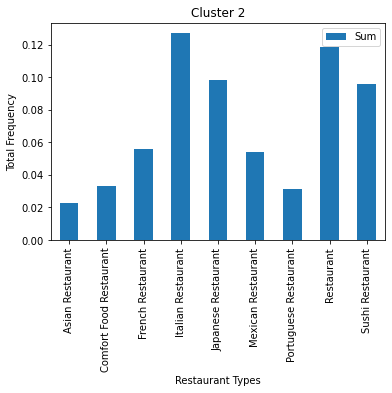

In [28]:
Restaurant_counts = clean.drop(['Cluster Labels','Neighborhood','Restaurant Total','Restaurant Variety'],axis=1).tail(1)

Restaurant_counts
x_pos1 = [i for i, _ in enumerate(Restaurant_types)]
Restaurant_counts.transpose().plot.bar(rot=0)

plt.title("Cluster 2")
plt.xlabel("Restaurant Types")
plt.ylabel("Total Frequency")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

### cluster 3

In [29]:
print("This is the cluster that has an okay number of restaurants. One can choose to open a restaurant here if must.")
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

This is the cluster that has an okay number of restaurants. One can choose to open a restaurant here if must.


,Neighborhood,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
4,Berczy Park,2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.018519,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.000000,0.018519,0.0,0.0,0.018519,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.037037,0.037037,0.018519,0.000000,0.018519,0.0,0.018519,0.00000,0.222222,10
8,"Harbourfront East, Union Station, Toronto Islands",2,0.0,0.0,0.000000,0.0,0.000000,0.010000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.010000,0.030000,0.010000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.030000,0.010000,0.010000,0.000000,0.000000,0.0,0.010000,0.00000,0.130000,9
12,"Kensington Market, Chinatown, Grange Park",2,0.0,0.0,0.016393,0.0,0.032787,0.000000,0.0,0.016393,0.016393,0.016393,0.000000,0.0,0.0,0.0,0.016393,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.016393,0.0,0.0,0.0,0.04918,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.065574,0.04918,0.295082,10
16,"St. James Town, Cabbagetown",2,0.0,0.0,0.000000,0.0,0.022222,0.022222,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.022222,0.044444,0.022222,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.044444,0.000000,0.000000,0.022222,0.022222,0.0,0.000000,0.00000,0.222222,8


In [30]:
cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
total = cluster.sum(axis=0)
total.name = 'Sum'
cluster = cluster.append(total)
cluster_summary = cluster.iloc[-1]
clean = cluster.drop([c for c in cluster.columns if cluster_summary[c]==0], axis=1)
clean.at['Sum', 'Restaurant Variety']=len(clean.columns) - 4
clean

,Neighborhood,Cluster Labels,Belgian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
4,Berczy Park,2,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.018519,0.000000,0.018519,0.018519,0.000000,0.000000,0.018519,0.00000,0.00,0.037037,0.037037,0.018519,0.000000,0.018519,0.018519,0.00000,0.222222,10
8,"Harbourfront East, Union Station, Toronto Islands",2,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.030000,0.010000,0.00000,0.01,0.030000,0.010000,0.010000,0.000000,0.000000,0.010000,0.00000,0.130000,9
12,"Kensington Market, Chinatown, Grange Park",2,0.016393,0.032787,0.000000,0.016393,0.016393,0.016393,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.016393,0.04918,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.065574,0.04918,0.295082,10
16,"St. James Town, Cabbagetown",2,0.000000,0.022222,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.044444,0.022222,0.00000,0.00,0.044444,0.000000,0.000000,0.022222,0.022222,0.000000,0.00000,0.222222,8
Sum,"Berczy ParkHarbourfront East, Union Station, T...",8,0.016393,0.055009,0.032222,0.034912,0.016393,0.016393,0.018519,0.016393,0.018519,0.018519,0.032222,0.074444,0.067134,0.04918,0.01,0.111481,0.047037,0.028519,0.022222,0.040741,0.094092,0.04918,0.869526,22


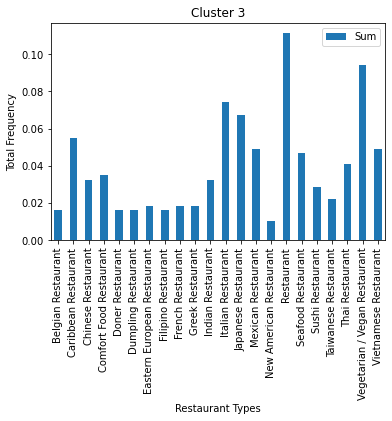

In [31]:
Restaurant_counts = clean.drop(['Cluster Labels','Neighborhood','Restaurant Total','Restaurant Variety'],axis=1).tail(1)

Restaurant_counts
x_pos1 = [i for i, _ in enumerate(Restaurant_types)]
Restaurant_counts.transpose().plot.bar(rot=0)

plt.title("Cluster 3")
plt.xlabel("Restaurant Types")
plt.ylabel("Total Frequency")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

### cluster 4

In [32]:
print("This is the cluster that has the least number of restaurants. One must not open a restaurant here.")
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

This is the cluster that has the least number of restaurants. One must not open a restaurant here.


,Neighborhood,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Total,Restaurant Variety
3,St. James Town,3,0.038462,0.012821,0.012821,0.000000,0.0,0.0,0.000000,0.012821,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.012821,0.012821,0.000000,0.00,0.0,0.025641,0.012821,0.0,0.000000,0.000000,0.0,0.012821,0.000000,0.0,0.025641,0.012821,0.0,0.0,0.025641,0.025641,0.000000,0.0,0.012821,0.0,0.012821,0.0,0.269231,15
7,"Richmond, Adelaide, King",3,0.021277,0.010638,0.000000,0.010638,0.0,0.0,0.010638,0.000000,0.0,0.0,0.0,0.0,0.0,0.010638,0.0,0.000000,0.000000,0.010638,0.00,0.0,0.000000,0.010638,0.0,0.010638,0.010638,0.0,0.000000,0.010638,0.0,0.000000,0.010638,0.0,0.0,0.042553,0.010638,0.021277,0.0,0.031915,0.0,0.010638,0.0,0.244681,16
17,"First Canadian Place, Underground city",3,0.030000,0.030000,0.000000,0.000000,0.0,0.0,0.010000,0.000000,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.000000,0.000000,0.010000,0.01,0.0,0.010000,0.040000,0.0,0.010000,0.010000,0.0,0.000000,0.000000,0.0,0.000000,0.010000,0.0,0.0,0.040000,0.030000,0.020000,0.0,0.020000,0.0,0.010000,0.0,0.300000,16


In [33]:
cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
total = cluster.sum(axis=0)
total.name = 'Sum'
cluster = cluster.append(total)
cluster_summary = cluster.iloc[-1]
clean = cluster.drop([c for c in cluster.columns if cluster_summary[c]==0], axis=1)
clean.at['Sum', 'Restaurant Variety']=len(clean.columns) - 4
clean

,Neighborhood,Cluster Labels,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Colombian Restaurant,Comfort Food Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Restaurant Total,Restaurant Variety
3,St. James Town,3,0.038462,0.012821,0.012821,0.000000,0.000000,0.012821,0.000000,0.012821,0.012821,0.000000,0.00,0.025641,0.012821,0.000000,0.000000,0.012821,0.000000,0.025641,0.012821,0.025641,0.025641,0.000000,0.012821,0.012821,0.269231,15
7,"Richmond, Adelaide, King",3,0.021277,0.010638,0.000000,0.010638,0.010638,0.000000,0.010638,0.000000,0.000000,0.010638,0.00,0.000000,0.010638,0.010638,0.010638,0.000000,0.010638,0.000000,0.010638,0.042553,0.010638,0.021277,0.031915,0.010638,0.244681,16
17,"First Canadian Place, Underground city",3,0.030000,0.030000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.01,0.010000,0.040000,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,0.040000,0.030000,0.020000,0.020000,0.010000,0.300000,16
Sum,"St. James TownRichmond, Adelaide, KingFirst Ca...",9,0.089738,0.053459,0.012821,0.010638,0.020638,0.012821,0.020638,0.012821,0.012821,0.020638,0.01,0.035641,0.063459,0.020638,0.020638,0.012821,0.010638,0.025641,0.033459,0.108194,0.066279,0.041277,0.064735,0.033459,0.813912,24


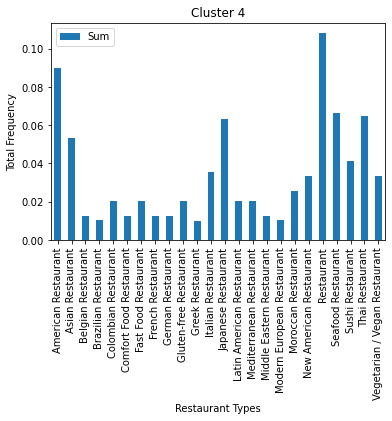

In [34]:
Restaurant_counts = clean.drop(['Cluster Labels','Neighborhood','Restaurant Total','Restaurant Variety'],axis=1).tail(1)

Restaurant_counts
x_pos1 = [i for i, _ in enumerate(Restaurant_types)]
Restaurant_counts.transpose().plot.bar(rot=0)

plt.title("Cluster 4")
plt.xlabel("Restaurant Types")
plt.ylabel("Total Frequency")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.show()